<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2025 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?labpath=1_OSI_SAF_sst_introductory%2F1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: SST anomalies use case</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- **<a href="https://osi-saf.eumetsat.int/register" target="_blank">A EUMETSAT OSI SAF account</a>** if you are using or plan to use the EUMETSAT OSI SAF data.
    
- **<a href="https://data.marine.copernicus.eu/register?redirect=%2Fproduct%2FSST_GLO_SST_L4_REP_OBSERVATIONS_010_024%2Ffiles%3Fpath%3DSST_GLO_SST_L4_REP_OBSERVATIONS_010_024%252FC3S-GLO-SST-L4-REP-OBS-SST_202506%252F" target="_blank">A COPERNICUS account</a>** if you are using or plan to use the COPERNICUS data to create the climatology by yourself.

There are no prerequisite notebooks for this module.
</div>
<hr>

# 2 Use case : Mapping Meteosat anomalies between daily SST and climatology
### Data used 

| Dataset | Collection ID | Website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Meteosat Sea Surface Temperature | EO:EUM:DAT:METEOSAT:OSIHSST-NC | <a href="https://osi-saf.eumetsat.int/products/osi-206-a" target="_blank">Description</a>| OSI-206-a | 
| ESA Sea Surface Temperature Climate Change Initiative (SST_cci): Climatology product, version 3.0 | / | <a href="https://doi.org/10.5285/62800d3d2227449085b430b503d36b01" target="_blank">Description</a>| / | 



### Learning outcomes

At the end of this notebook you will know;
* How to open Metosat SST netcdf
* Create your own climatology
* Map SST using cartopy 
* Map SST anomalies

### Outline

Data from OSI SAF is available through multiple sources. Here we will guide you through FTP access to OSI SAF SST Data.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Creating our workspace](#section1)
 1. [Setting login information](#section2)
 1. [Download the Near Real Time satellite data](#section3)
 1. [Download and create the climatology](#section4)
 1. [Open data files](#section5)
 1. [Manipulate variables](#section6)
 1. [Mapping the SST](#section7)
 1. [Mapping the SST anomalies](#section8)
 


<hr>

This notebook presents a method to <b>analyze sea surface temperature (SST) anomalies</b> using satellite and climatological data. The goal is to identify regions where measured temperatures deviate from the seasonal average for this date, enabling detection of unusual phenomena such as unsual heat wave/cold spell.

An SST anomaly represents the difference between the <b>observed sea surface temperature and the expected average </b>for a specific date.

The data used include:

   - 24 hourly geostationnary satellite files from August 31, 2024.
   
   - A climatological reference generated from 30 historical files, providing the average SST for August 31 over climatology period, 30 years (1991-2020).

To ensure reliability, for each geographic location, the darkest hour of the night is selected (based on the solar zenith angle), and the corresponding SST is used, a moment when the sea surface is least influenced by sunlight, allowing the temperature to closely approximate the foundation temperature (to be able to compare with climatology), which is more stable and representative of actual ocean conditions.

The final output <b>is a anomaly map</b> (in °C), highlighting areas where SSTs show how much it differ from the climatological norm.

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Creating the workspace
[Back to top](#TOC-TOP)

</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library import 
import numpy as np                 # for numerical operations and multi-dimensional arrays
import xarray as xr                # for working with labeled multi-dimensional datasets (e.g., NetCDF)
from netCDF4 import Dataset        # lower-level alternative to xarray for reading/writing NetCDF files
import matplotlib.pyplot as plt    # for plotting graphs and data visualizations
import matplotlib.cm as mpl_cm     # for accessing color maps for plots
import cartopy.crs as ccrs         # for map projections and geographic coordinate systems
import cartopy.feature as cfeature # for adding geographic features like coastlines, borders, etc.
import os                          # for interacting with the file system (paths, folders, etc.)
import shutil                      # for moving, copying, or deleting files and directories
import urllib                      # for handling URLs and downloading data from the internet
import ftplib                      # for connecting to FTP servers and downloading files
import datetime                    # for manipulating dates and timestamps
import json                        # for reading and writing JSON format data

Next we will create a download directory to store the products we will download in this notebook.

In [13]:
# create a folder
download_dir = os.path.join(os.getcwd(), "data")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Setting login information
[Back to top](#TOC-TOP)

</div>

We will access OSI SAF data from the OSI SAF Lower-Mid-Latitude Centre FTP server.

In order to allow us to download data, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumetsat_osi_saf_sst_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

#### Option 1: creating  `.eumetsat_osi_saf_sst_credentials` in our home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"username": "anonymous",
"password": "anonymous"
}
```

Make sure to save the file without any kind of extension.

Once you have done this, you can read in your credentials using the commands in the following cell. These will be used to generate a time-limited token, which will refresh itself when it expires.

Reading credential information.

In [3]:
# read credentials
with open(os.path.join(os.path.expanduser("~"),'.eumetsat_osi_saf_sst_credentials')) as json_file:
    credentials = json.load(json_file)

Loading credentials.

In [4]:
username = credentials['username'] 
password = credentials['password']

Option 2: provide credentials directly
You can provide your credentials directly as follows; by uncommenting the following lines.

In [ ]:
#username = "provided_username"
#password = "provided_password"

You must replace provided_username and provided_password with the information provided to you after you have registered to the OSI SAF website and mentionned your interest in SST data.

Once you have created an EUMETSAT OSI SAF account, the generic password and credentials to access OSI SAF Lower-Mid-Latitude  server should have been sent to you via email.

Note: this method is convenient in the short term, but is not really recommended as you have to put your provided username and password in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Download the Near Real Time satellite data
[Back to top](#TOC-TOP)

</div>

In this section, we will download SST products from OSI-SAF. Each product corresponds to a hour.

We use one file per hour because files are from a <b>geostationary satellite</b>, wich is always watching the same points on Earth. Moreover, 24 files will <b>decrease the influence of clouds</b> on the map because we will have multiples data for one pixel.

### Meteosat Daily Sea Surface Temperature :

Let's start by creating a specific folder to hold the Meteosat Sea Surface Temperature products.

In [14]:
# create a folder
download_dir = os.path.join(os.getcwd(), "data", "L3_Meteosat_0°")
os.makedirs(download_dir, exist_ok=True)

We select the date.


In [15]:
# select date
Year, Month, Day = 2025, 6, 30
product = 'Meteosat 0° SEVIRI SST'

Month_str = "{:02d}".format(Month)
Day_str = "{:02d}".format(Day)
Date_str = Day_str+'/'+Month_str+'/'+str(Year)
day_of_year = "{:03d}".format(datetime.datetime(Year, Month, Day).timetuple().tm_yday) # Calcul the day number of the year

print('Day of year for',Date_str,': ',day_of_year)

Day of year for 30/06/2025 :  181


Set the download path.

In [18]:
# the path where we find the netCDF files for each hour
path = '/ifremer/cersat/projects/osisaf/sst/l3c/east_atlantic_west_indian/mtg/' + str(Year) + '/' + day_of_year

We connect to the ftp and we download each 24 files, one per hour. We can print every filename to make sur there are every 24 files.

In [19]:
# connect ftp and download file
ftp = ftplib.FTP("ftp.ifremer.fr") 
ftp.login(username, password)
ftp.cwd(path)
for i in range (24):    # a loop executed 24 times in order to get netCDF files for each hour of the day ( from 00 am to 11 pm)
    Hour = i
    Hour_str = "{:02d}".format(Hour)
    # files' name we are looking for to get our SST data. Each file depend on the day and the hour. With the loop, we have access to every file from this path for the 31 august of 2024
    filename = str(Year) + Month_str + Day_str + \
    Hour_str + '0000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc'           
    print(filename)
    try:     
        ftp.retrbinary("RETR " + filename, open(os.path.join(os.getcwd(), 'data', 'L3_Meteosat_0°', filename), 'wb').write)   #réecriture des fichiers dans le dossier "global_GHRSST"
    except: 
        None
ftp.quit()   # quit the FTP

20250630000000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630010000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630020000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630030000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630040000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630050000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630060000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630070000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630080000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630090000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630100000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630110000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630120000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630130000-OSISAF-L3C

'221 Goodbye.'

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Download and create the climatology
[Back to top](#TOC-TOP)

</div>

To compute SST climatology for a specific day (in this example, August 31), we need to gather the SST data for that day from 1991 to 2020.

The files are available on <a href="https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_024/files?path=SST_GLO_SST_L4_REP_OBSERVATIONS_010_024%2FC3S-GLO-SST-L4-REP-OBS-SST_202506%2F" target="_blank">COPERNICUS website</a>, we have to download the SST files corresponding to August 31 (for each year) from 1991 to 2020 (both included). Once downloaded, we will place the files in the `products/clim` directory.

In [9]:
# create a folder
download_dir = os.path.join(os.getcwd(), "products", "clim")
os.makedirs(download_dir, exist_ok=True)

we need to connect to Copernicus to be able to download the files. Once you execute the cell bellow, you have to write your login and your password for Copernicus and write "y".

In [11]:
login()

INFO - 2025-07-09T06:51:08Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:Copernicus Marine password:File /home/allaine/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

INFO - 2025-07-09T06:51:22Z - Credentials file stored in /home/allaine/.copernicusmarine/.copernicusmarine-credentials.


True

Let’s download the Copernicus files from August 31 from 1991 to 2020 

In [12]:
for year in range(1991, 2021):
    # we only want 31 August's files
    date_filter = f"*{year}083112*"
    get(
        dataset_id ="C3S-GLO-SST-L4-REP-OBS-SST",
        filter = date_filter,
    )

INFO - 2025-07-09T06:51:28Z - Selected dataset version: "202506"
INFO - 2025-07-09T06:51:28Z - Selected dataset part: "default"
INFO - 2025-07-09T06:51:28Z - Listing files on remote server...
16it [00:03,  4.08it/s]
INFO - 2025-07-09T06:51:38Z - Selected dataset version: "202506"
INFO - 2025-07-09T06:51:38Z - Selected dataset part: "default"
INFO - 2025-07-09T06:51:38Z - Listing files on remote server...
16it [00:03,  4.24it/s]
INFO - 2025-07-09T06:51:47Z - Selected dataset version: "202506"
INFO - 2025-07-09T06:51:47Z - Selected dataset part: "default"
INFO - 2025-07-09T06:51:47Z - Listing files on remote server...
16it [00:04,  3.91it/s]
INFO - 2025-07-09T06:51:57Z - Selected dataset version: "202506"
INFO - 2025-07-09T06:51:57Z - Selected dataset part: "default"
INFO - 2025-07-09T06:51:57Z - Listing files on remote server...
16it [00:04,  3.98it/s]
INFO - 2025-07-09T06:52:06Z - Selected dataset version: "202506"
INFO - 2025-07-09T06:52:06Z - Selected dataset part: "default"
INFO - 2

In [13]:
source_root =  "SST_GLO_SST_L4_REP_OBSERVATIONS_010_024/C3S-GLO-SST-L4-REP-OBS-SST_202506" 
target_dir = "products/clim"

os.makedirs(target_dir, exist_ok=True)

for root, dirs, files in os.walk(source_root):
    for file in files:
        if file.endswith(".nc"):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(target_dir, file)
            shutil.move(src_path, dst_path)

In [14]:
for root, dirs, files in os.walk(source_root, topdown=False):
    if not os.listdir(root):
        os.rmdir(root)

To build the SST climatology, we have to calculate the <b>average SST</b> for August 31 over the 30-year period using the downloaded netCDF files.

As we have 30 files, we can put them in a list named "climsets" in order to use them easily after.

In [10]:
# path where the files are stored
directory = os.path.join(os.getcwd(), 'products', 'clim')

# creation of a "climsets" list to quickly access open files
climsets = []

# search for netCDF files in the "clim" directory
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        
        # open the netCDF files
        nc = xr.open_dataset(os.path.join(directory, filename))
        print(nc)
        # adding the open netCDF files to the "climsets" list
        climsets.append(nc)


<xarray.Dataset> Size: 726MB
Dimensions:                (lon: 7200, lat: 3600, time: 1)
Coordinates:
  * lon                    (lon) float32 29kB -180.0 -179.9 ... 179.9 180.0
  * lat                    (lat) float32 14kB -89.97 -89.92 ... 89.93 89.98
  * time                   (time) datetime64[ns] 8B 2002-08-31T12:00:00
Data variables:
    analysed_st            (time, lat, lon) float32 104MB ...
    analysis_error_st      (time, lat, lon) float32 104MB ...
    mask                   (time, lat, lon) float32 104MB ...
    sea_ice_fraction       (time, lat, lon) float32 104MB ...
    analysed_sst           (time, lat, lon) float32 104MB ...
    sea_ice_fraction_flag  (time, lat, lon) float32 104MB ...
    analysis_error_sst     (time, lat, lon) float32 104MB ...
Attributes: (12/48)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Global Sea and Ice Surface Temperature, L4, 5...
    summary:                    DMI Sea and Ice Sur

We can print every open files to see variables.

In [16]:
# display of netCDF files
for i in range (len(climsets)):
    print(climsets[i])
    print("")

<xarray.Dataset> Size: 726MB
Dimensions:                (lon: 7200, lat: 3600, time: 1)
Coordinates:
  * lon                    (lon) float32 29kB -180.0 -179.9 ... 179.9 180.0
  * lat                    (lat) float32 14kB -89.97 -89.92 ... 89.93 89.98
  * time                   (time) datetime64[ns] 8B 2002-08-31T12:00:00
Data variables:
    analysed_st            (time, lat, lon) float32 104MB ...
    analysis_error_st      (time, lat, lon) float32 104MB ...
    mask                   (time, lat, lon) float32 104MB ...
    sea_ice_fraction       (time, lat, lon) float32 104MB ...
    analysed_sst           (time, lat, lon) float32 104MB ...
    sea_ice_fraction_flag  (time, lat, lon) float32 104MB ...
    analysis_error_sst     (time, lat, lon) float32 104MB ...
Attributes: (12/48)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Global Sea and Ice Surface Temperature, L4, 5...
    summary:                    DMI Sea and Ice Sur

To perform the SST average, we need to extract from the 30 files the associated SST variables and average them by stacking the list of tables in a larger table.

In [35]:
# creation of a list in order to store SST variables
sst_data = []

# loop of the file number size (normally 30) which allows adding SST variables to it list
for i in range (len(climsets)):
    sst_data.append(climsets[i]['analysed_sst'])
    
# stack the tables' list into a table with an additional dimension    
sst_data_stack = xr.concat(sst_data, dim='time')

# calcul the SST's average in this table
sst_clim = sst_data_stack.mean(dim='time')

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Open data files
[Back to top](#TOC-TOP)

</div>

As we have 24 files, we can put them in a list we named "datasets" in order to use them easily after.

In [21]:
# path where the files are stored
directory = os.path.join(os.getcwd(), 'products' , 'meteosat')

# creation of a "datasets" list to quickly access open files
datasets = []

# search for netCDF files in the "meteosat" directory
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        
        # open the netCDF files
        nc = xr.open_dataset(os.path.join(directory, filename))
        
        # adding the netCDF files to the "datasets" list by adding them at the end
        datasets.append(nc)

/tmp/ipykernel_1028882/1162231929.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  nc = xr.open_dataset(os.path.join(directory, filename))
/tmp/ipykernel_1028882/1162231929.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta6

We can print every open files to see variables.


In [22]:
# display of netCDF files
for i in range (len(datasets)):
    print(datasets[i])
    print("")

<xarray.Dataset> Size: 668MB
Dimensions:                    (time: 1, lat: 2400, lon: 2400)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2024-08-31T16:00:00
  * lat                        (lat) float32 10kB -59.97 -59.92 ... 59.92 59.97
  * lon                        (lon) float32 10kB -59.97 -59.92 ... 59.92 59.97
Data variables: (12/16)
    sea_surface_temperature    (time, lat, lon) float64 46MB ...
    sst_dtime                  (time, lat, lon) timedelta64[ns] 46MB ...
    sses_bias                  (time, lat, lon) float64 46MB ...
    sses_standard_deviation    (time, lat, lon) float64 46MB ...
    dt_analysis                (time, lat, lon) float64 46MB ...
    wind_speed                 (time, lat, lon) float64 46MB ...
    ...                         ...
    l2p_flags                  (time, lat, lon) int32 23MB ...
    quality_level              (time, lat, lon) float32 23MB ...
    satellite_zenith_angle     (time, lat, lon) float64 46MB ...
    sola

<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Manipulate variables
[Back to top](#TOC-TOP)

</div>

In this part, we will use some variables like <b>sst, quality level and azimutal angle</b> in order to have the more realistic SST map. Indeed, the real SST is equal to the temperature measured by the satellite when it is dark because during the day, the sun warms up the small layer of water surface which is measured by the satellite by a few tenths of a degree or even several degrees. We are looking for what comes closest to the foundation temperature (climatolgy SST), which is defined as the minimum reached at night by the <b>subskin temperature</b>, the SST of the geostationary OSI SAF.

<img src='https://www.ukargo.net/about/technology/near_surface_temperature/images/near_surface_temperature.jpg' width='100%'/>

<div style="text-align: center;">
  <a href="https://www.ghrsst.org/wp-content/uploads/2021/04/SSTDefinitionsDiscussion.pdf" target="_blank">
    Near-surface oceanic temperature gradients by Peter Minnett and Andrea Kaiser-Weiss (2012)
  </a>
</div>

<b>A</b> : night or strong wind condition <br>
<b>B</b> : day and light wind

We can see the climatology data in blue, the SST foundation wich is almost equal to the subskin SST in yellow, the daily SST.

We have to extract 5 variables (latitude, longitude, quality level, SST and solar angle) on each 24 files to use them.

In [23]:
# creation of a list in order to store each variable of each file in an array which is itself in a list with the other arrays of different files
sst_sat = []
ql_sat = []
solar_angle = []
Ql_sst_sat = []


# storage of the variables lon and lat in their respective table, the longitude and latitude are equal for each file
lon_sat = datasets[0].variables['lon']
lat_sat = datasets[0].variables['lat']

# loop of the file number size (normally 24) which allows adding each variable array to its list
for i in range(len(datasets)):
    sst_sat.append(datasets[i].variables['sea_surface_temperature'][:])
    ql_sat.append(datasets[i].variables['quality_level'][:])
    solar_angle.append(datasets[i].variables['solar_zenith_angle'][:])

Then, we have to selects, for <b>each pixel</b> (lat, lon), the sea surface temperature (SST) measured at the darkest hour of the night, meaning the time when the solar angle is highest and the data quality is good enough (≥ 4).
It uses <b>masks</b> to ignore poor-quality or daytime data.

<img src='https://i.postimg.cc/tgjJfN54/Earth-4.png' width='100%'/>

A 0° solar zenith angle correspond at the middle of the day and a 180° solar zenith angle correspond at the middle of the night, so a 90° solar zenith angle correspond to a sunrise or a sunset. We took 180° because it's not possible to take colder because of clouds' border. We use the <b>solar zenith angle instead of the time</b> because, as the satellite is always pointing to the same point, UTC = time at the nadir (= the point on earth surface right below the satellite) don't correspond to geostationnary disk (= what the satellite view) time on every points.

In [24]:
# conversion to array numpy
sst_sat = np.array(sst_sat)    # shape (N, 1, H, W)
ql_sat = np.array(ql_sat)
solar_angle = np.array(solar_angle)


# suppression of unnecessary data
sst_sat = np.squeeze(sst_sat, axis=1)
ql_sat = np.squeeze(ql_sat, axis=1)
solar_angle = np.squeeze(solar_angle, axis=1)

# creation of the combined mask: sufficient quality and solar angle > 95 (night) 
valid_mask = (np.array(ql_sat) >= 4) & (np.array(solar_angle) > 95)

# masking of invalid SST
Ql_sst_mask = np.ma.masked_where(~valid_mask, sst_sat)

# masking of invalid solar angles
angle_mask = np.ma.masked_where(~valid_mask, solar_angle)

# search for the index of the time when the solar angle is maximal (darkest night)
best_hour_index = np.ma.argmax(angle_mask, axis=0)  #shape (H, W)

# recovery of dimensions
N, H, W = Ql_sst_mask.shape

#spatial indices to extract SST
rows = np.arange(H)[:, None]
cols = np.arange(W)

# extraction of SST corresponding to the time with the darkest night and good quality
result_sst = Ql_sst_mask[best_hour_index, rows, cols]

We have to rearrange the shape to be able to manipulate the result afterwards.


In [25]:
# add a time dimension equal to 1
result_sst = np.expand_dims(result_sst, axis = 0)

# check the shape of the result
print(result_sst.shape)

(1, 2400, 2400)


<div class="alert alert-info" role="alert">

## <a id='section7'></a>7. Mapping the SST
[Back to top](#TOC-TOP)

</div>

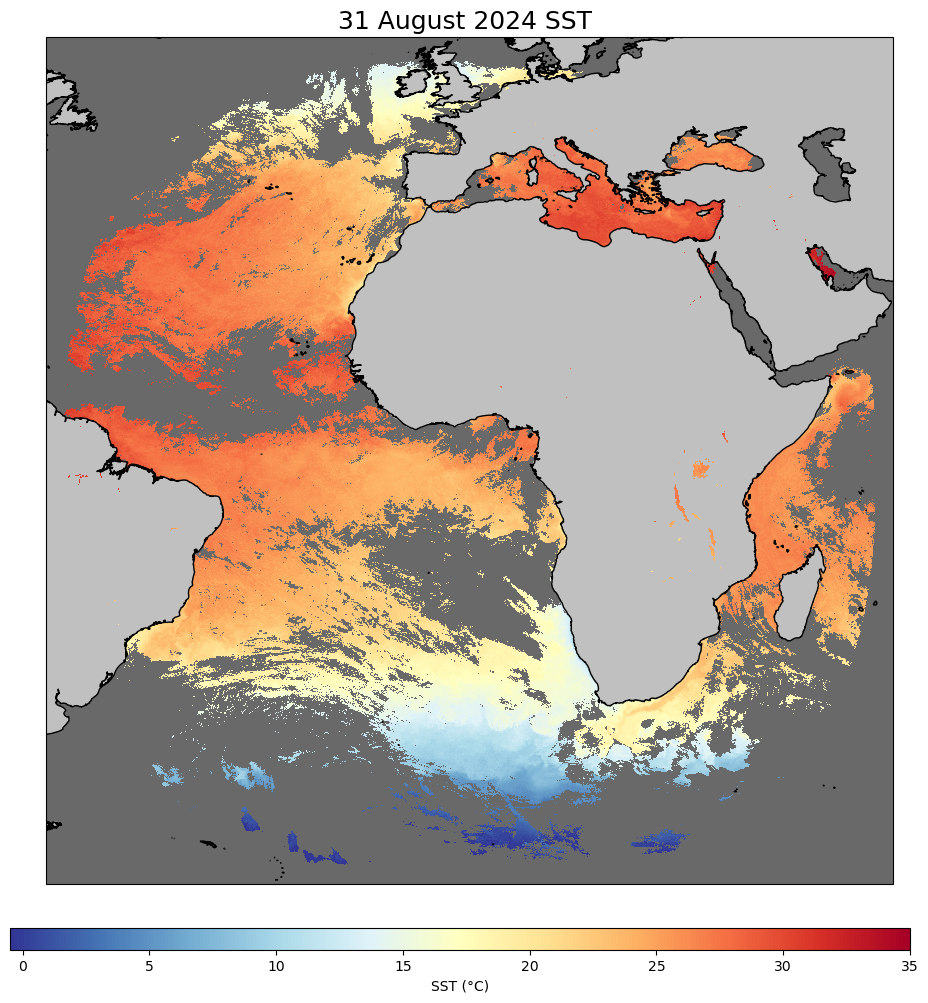

In [26]:
# create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# add card features
ax.add_feature(cfeature.LAND, facecolor='silver')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='dimgrey')

# draw coastline
ax.coastlines('10m')

# create a map of the SST(the SST in Kelvin is here converted in °Celius) 
c = ax.pcolormesh(lon_sat, lat_sat, result_sst[0, :, :]-273.15, cmap='RdYlBu_r', shading='auto')
c.set_clim(-0.5,35)


# add a colorbar
fig.colorbar(c, ax=fig.add_axes([0.3,0.5,0.3,0.1], anchor='S', zorder=-1 ), cax = fig.add_axes((0.13,0.05,0.75,0.02)), orientation='horizontal', label='SST (°C)')

# add a title
ax.set_title('31 August 2024 SST ', fontdict={'fontsize': 18})

# show the map
plt.show()

<div class="alert alert-info" role="alert">

## <a id='section8'></a>8. Mapping the SST anomalies
[Back to top](#TOC-TOP)

</div>

We have to reduce longitude and latitude from the climatology file to compare with the SST.

In [39]:
# reduce the longitudes and latitudes of the climatology file in order to have two files with the same latitude and longitude to be able to compare them
sst_clim = sst_clim.sel(lon=lon_sat, lat=lat_sat, method="nearest")

When lontitude and latitude are the them between both, we can calcul the difference.

In [40]:
diff_sst = result_sst - sst_clim

When we have the difference, we can plot it !


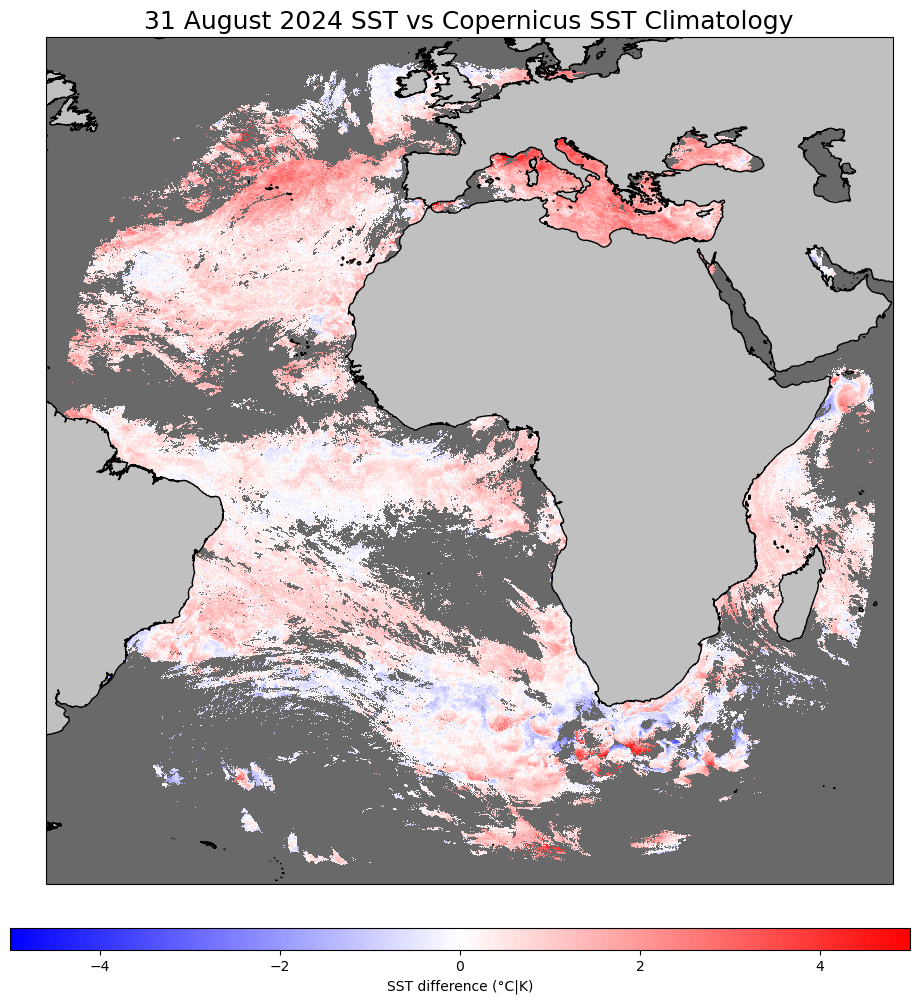

In [42]:
# create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# add card features
ax.add_feature(cfeature.LAND, facecolor='silver')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='dimgrey')

# Draw coastline
ax.coastlines('10m')

# create a map of the temperature difference
c = ax.pcolormesh(lon_sat, lat_sat, diff_sst[0, :, :], cmap='bwr', shading='auto')
c.set_clim(-5,5)

# add a colorbar
fig.colorbar(c, ax=fig.add_axes([0.3,0.5,0.3,0.1], anchor='S', zorder=-1 ), cax = fig.add_axes((0.13,0.05,0.75,0.02)), orientation='horizontal', label='SST difference (°C|K)')

# add a title
ax.set_title('31 August 2024 SST vs Copernicus SST Climatology', fontdict={'fontsize': 18})

# show the map
plt.show()